# **Data Mining to Analyze and Prevent Vehicular Crashes**

Importing the libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
pd.set_option('display.max_columns', None)

**PLEASE RUN THE WGET COMMAND BELOW IF YOU ARE RESTARTING THE KERNEL**

In [0]:
# run this to import the dataset into memory prior to loading into the df
#  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Q6yMJ39_5v7EIIXSh0KCgPOJDogUjCZ1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Q6yMJ39_5v7EIIXSh0KCgPOJDogUjCZ1" -O US.csv && rm -rf /tmp/cookies.txt


Loading the entire dataset and Massachussetts dataset

In [0]:
df = pd.read_csv("./US.csv")
ma_dataset = df[df['State'] == 'MA'].copy()

In [0]:
text_data = df[['Description','Severity']].sample(n=1000, random_state=10)
text_data.head()

,Description,Severity
2355736,At I-280/OH-420/Exit 71 - Accident.,2
1755961,Accident on I-476 Southbound from Exit 44 to E...,3
1695530,Right hand shoulder blocked due to accident on...,3
1608215,Accident on Memorial Hwy at Independence Pkwy.,2
1774276,Accident on I-805 Southbound at Exit 21 CA-274...,3


Get the counties with most number of accidents based on Severity.

In [0]:
df.groupby(['County'])['Severity'].size().sort_values(ascending=False).head(50)

County
Los Angeles         227180
Harris               99134
Orange               75970
Mecklenburg          72762
Dallas               68558
Travis               63603
Montgomery           57256
Wake                 52640
Maricopa             45524
Alameda              45367
San Diego            41829
Miami-Dade           39473
Davidson             36415
Sacramento           35795
San Bernardino       35754
King                 35686
Santa Clara          34521
Riverside            32911
East Baton Rouge     31732
Fulton               31462
Oklahoma             30783
Cook                 30467
Genesee              27608
Douglas              25725
Marion               25425
Jefferson            25407
Hennepin             24655
Wayne                23738
Contra Costa         23059
Lake                 22712
Bexar                22206
Greenville           22190
Broward              19617
Hillsborough         19593
Salt Lake            18372
Middlesex            18097
Westchester          

We could see that Los Angeles is the county having the most severe and the most number of accidents followed by Harris and Orange. We could also see that most of the counties are from California and Texas having most severe accidents.

### Dataset Info

In [0]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TMC,2246264.0,207.831632,20.329586,200.000000,201.000000,201.000000,201.000000,4.060000e+02
Severity,2974335.0,2.360190,0.541473,1.000000,2.000000,2.000000,3.000000,4.000000e+00
Start_Lat,2974335.0,36.493605,4.918849,24.555269,33.550402,35.849689,40.370260,4.900220e+01
Start_Lng,2974335.0,-95.426254,17.218806,-124.623833,-117.291985,-90.250832,-80.918915,-6.711317e+01
End_Lat,728071.0,37.580871,5.004757,24.570110,33.957554,37.903670,41.372630,4.907500e+01
End_Lng,728071.0,-99.976032,18.416647,-124.497829,-118.286610,-96.631690,-82.323850,-6.710924e+01
Distance(mi),2974335.0,0.285565,1.548392,0.000000,0.000000,0.000000,0.010000,3.336300e+02
Number,1056730.0,5837.003544,15159.278074,0.000000,837.000000,2717.000000,7000.000000,9.999997e+06
Temperature(F),2918272.0,62.351203,18.788549,-77.800000,50.000000,64.400000,76.000000,1.706000e+02
Wind_Chill(F),1121712.0,51.326849,25.191271,-65.900000,32.000000,54.000000,73.000000,1.150000e+02


In [0]:
# Information on dimensionality of dataset - (rows, columns)
df.shape

(2974335, 49)

In [0]:
df.index

RangeIndex(start=0, stop=2974335, step=1)

In [0]:
# Attribute names of the dataset.
df.columns 

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

Information regarding the dataset.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

We could see that the dataset has a total of 48 columns out of which 13 are of boolean type, 14 are float type, one is an integer type and the rest 21 are objects.

In [0]:
# Count of null entries by attribute
df.isnull().sum()

ID                             0
Source                         0
TMC                       728071
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2246264
End_Lng                  2246264
Distance(mi)                   0
Description                    1
Number                   1917605
Street                         0
Side                           0
City                          83
County                         0
State                          0
Zipcode                      880
Country                        0
Timezone                    3163
Airport_Code                5691
Weather_Timestamp          36705
Temperature(F)             56063
Wind_Chill(F)            1852623
Humidity(%)                59173
Pressure(in)               48142
Visibility(mi)             65691
Wind_Direction             45101
Wind_Speed(mph)           440840
Precipitat

We could observe that most of the latitude-longitude features, weather conditions like precipitation and wind_chill are nulls.

### Data Visualizations

In [0]:
# Aggregate of severity by state and then unstack it
severity_by_state = df.groupby(['State', 'Severity']).agg({'Severity': [np.size]})
unstacked_severity_by_state = severity_by_state.unstack()

##### Correlation Heatmap of features

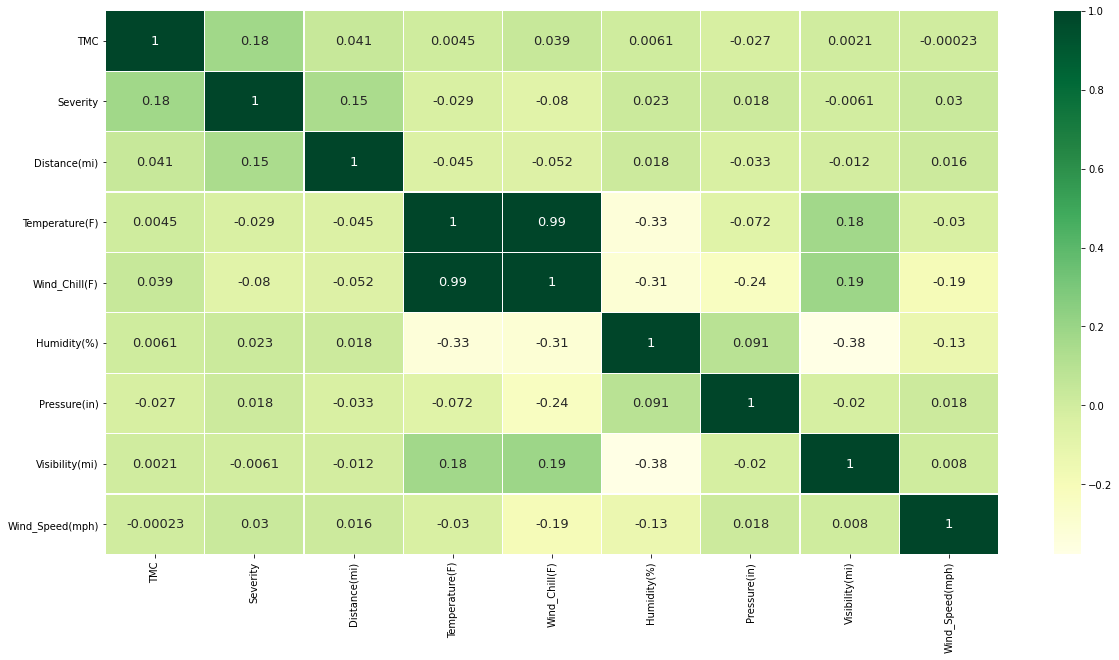

In [0]:
# Correlation heatmap of Key Numeric features
fig=sns.heatmap(df[['TMC','Severity','Distance(mi)',
                    'Temperature(F)','Wind_Chill(F)','Humidity(%)',
                    'Pressure(in)','Visibility(mi)','Wind_Speed(mph)']].corr(),
                annot=True,cmap='YlGn',linewidths=0.2,annot_kws={'size':13})
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

We performed correlation analysis on our dataset to check
the correlated features in the dataset as some algorithms
assume independence and having highly correlated features
can lead to misclassification in some algorithms. Correlation
is an important factor while choosing algorithms. 

We can observe here that among our key features only Wind Chill and Temperature have high correlation. The Boolean features have  ever lesser correlation 

#### Stacked bar graph - All States

* As you see from the stacked bar graph, California has the most accidents, Texas the second most and Florida the third most.

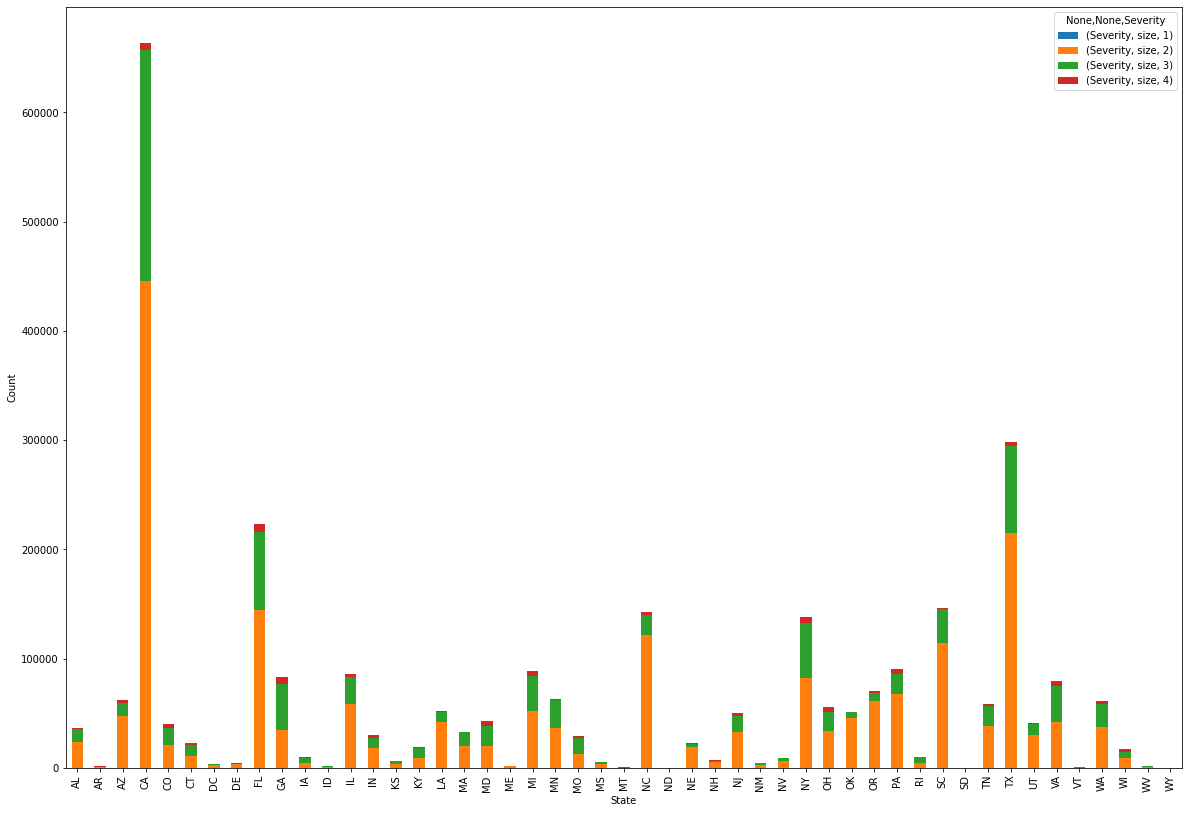

In [0]:
# Stacked bar graph all 50 states
fig, ax = plt.subplots(figsize=(20,14))
ax.set_ylabel("Count")
unstacked_severity_by_state.plot(kind='bar', ax=ax, stacked=True)

In [0]:
# severity is either 1,2,3, or 4
def top_ten_states_by_severity(severity):
  return unstacked_severity_by_state.sort_values(by=[('Severity', 'size', severity)], ascending=False)[:10]

#### Stacked bar graph - Top 10 States

* Below we rank the top 10 states by each severity category. California is ranked number one in accidents with severities 1, 2 and 3. It is interesting to note that Georgia has significantly less accidents but has the most accidents with a 4 severity and Florida has the most in this category. What is also interesting to note is that Texas is ranked top 3 in each severity 1, 2, and 3, but they are last in severity 4. Florida is ranked top 3 in each severity category.

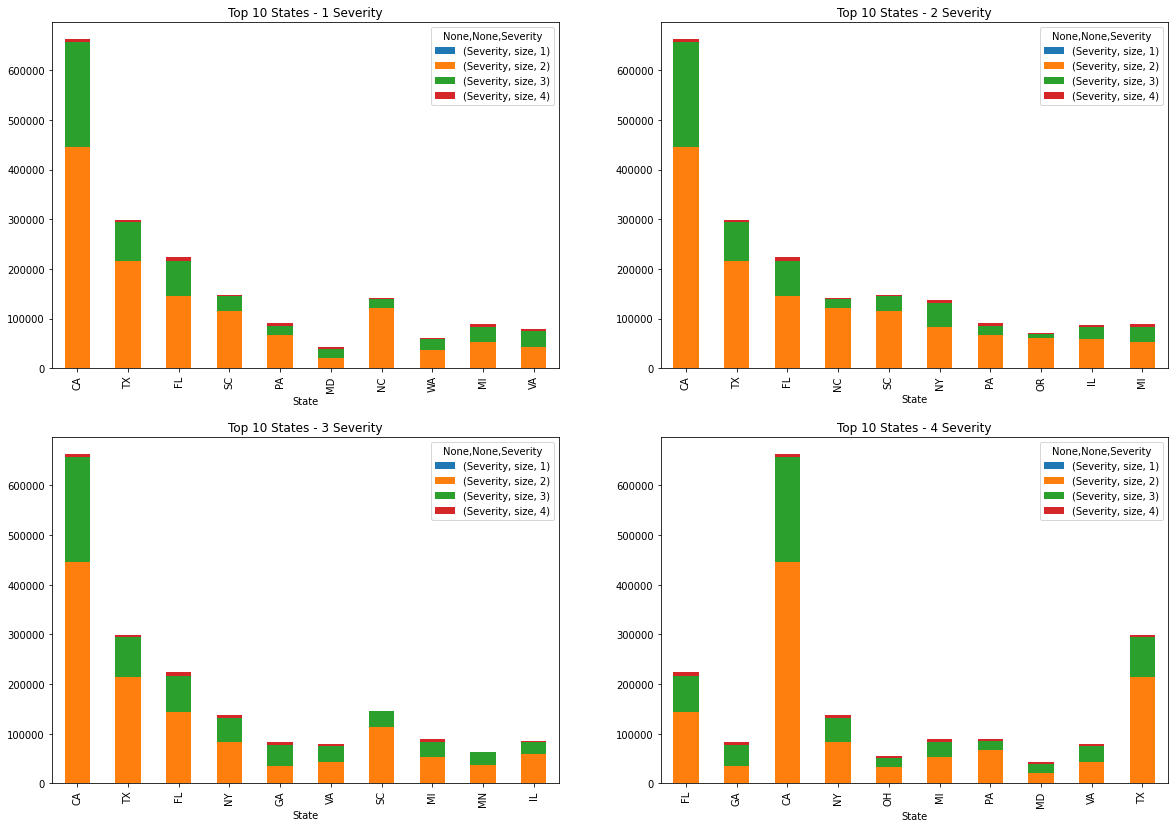

In [0]:
# Stacked bar graphs for top 10 states with severity 1,2,3, and 4
fig = plt.figure(figsize=(20,14))
title_templ = "Top 10 States - {} Severity"
top_ten_states_by_severity(1).plot(kind='bar', ax=fig.add_subplot(221), title=title_templ.format(1), stacked=True)
top_ten_states_by_severity(2).plot(kind='bar', ax=fig.add_subplot(222), title=title_templ.format(2), stacked=True)
top_ten_states_by_severity(3).plot(kind='bar', ax=fig.add_subplot(223), title=title_templ.format(3), stacked=True)
top_ten_states_by_severity(4).plot(kind='bar', ax=fig.add_subplot(224), title=title_templ.format(4), stacked=True)

 Statistics for accidents based on zone - (US)

In [0]:
# Create attributes for incident tables
ID = ['Amenity', 'Bump', 'Crossing', 'Give_way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'];
Num_Incidences = [35220, 454, 207590, 7627, 238447, 3395, 25161, 168, 56413, 40160, 1111, 503383, 0];

In [0]:
# List attributes as data
y = list(zip(ID, Num_Incidences))

In [0]:
# Create incident table
INCTable = pd.DataFrame(data = y, columns = ['Zone', 'Incident_Count'], index = ['Amenity', 'Bump', 'Crossing', 'Give_way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'])

In [0]:
INCTable

,Zone,Incident_Count
Amenity,Amenity,35220
Bump,Bump,454
Crossing,Crossing,207590
Give_way,Give_way,7627
Junction,Junction,238447
No_Exit,No_Exit,3395
Railway,Railway,25161
Roundabout,Roundabout,168
Station,Station,56413
Stop,Stop,40160


#### Accident Zones - Bar Graph

Text(0.5, 1.0, 'count of accidents per zone')

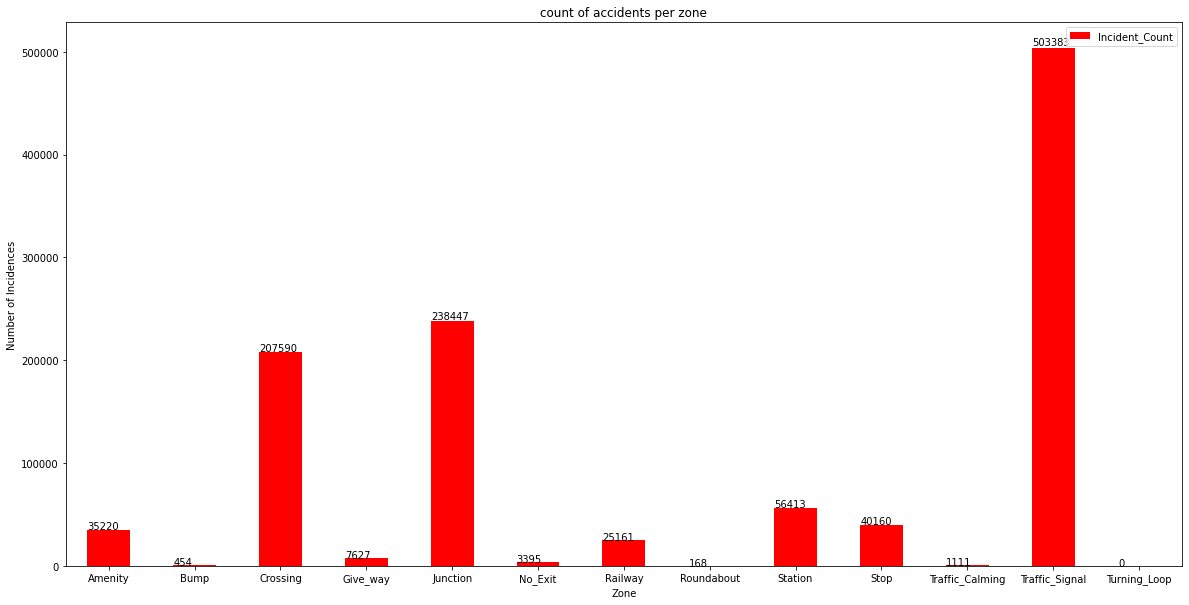

In [0]:
# Plot stats for accident zones 
ax = INCTable.plot.bar(x='Zone', y='Incident_Count', rot=0, figsize=(20,10), color = ['r']); 
for p in ax.patches:    
  ax.annotate(str(p.get_height()), (p.get_x() * 1.0005, p.get_height() * 1.005)); 
  
ax.set_xlabel('Zone') 
ax.set_ylabel('Number of Incidences') 
ax.set_title('count of accidents per zone')

The bar plot representing count of accidents at different areas indicates that the highest number of accidents have occurred in areas with traffic signals. 

#### Word Cloud - Weather conditions

Word Cloud 


Bolder the word (weather condition) implies more accidents have taken during that weather condition

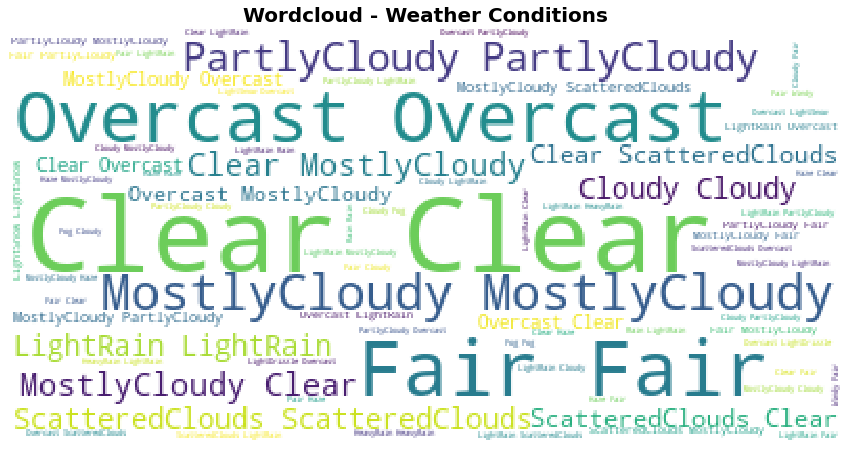

In [0]:
# Process text in the weather text
def processText(text):
    try:
        textlist = text.split('/')
        for i in range(len(textlist)):
            textlist[i] = textlist[i].split(' ')
            if '' in textlist[i]:
                textlist[i].remove('')
            textlist[i] = ''.join(textlist[i])
            text = '/'.join(textlist)
            return text
    except Exception as e:
        print(text)
        print(e)
   
weather_data  = df['Weather_Condition'].dropna()
# weather = data.groupby(data).size().reset_index(name='Count').set_index('Weather_Condition').sort_values(by='Count',ascending=False)                
weather_data = weather_data.apply(processText)

#Test weather_data works
# weather_data
#All text into single string
text = ' '.join(weather_data.values.tolist())
wordcloud = WordCloud(background_color="white").generate(text)

# Plot the word cloud

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.set_title('Wordcloud - Weather Conditions',fontdict={'fontsize': 20, 'fontweight' : 'bold', 'verticalalignment': 'center', 'horizontalalignment': 'center'})
plt.imshow(wordcloud, interpolation='nearest')
plt.axis("off")
plt.show()

#### Joint Plot - Latitude vs Longitude

JointPlot

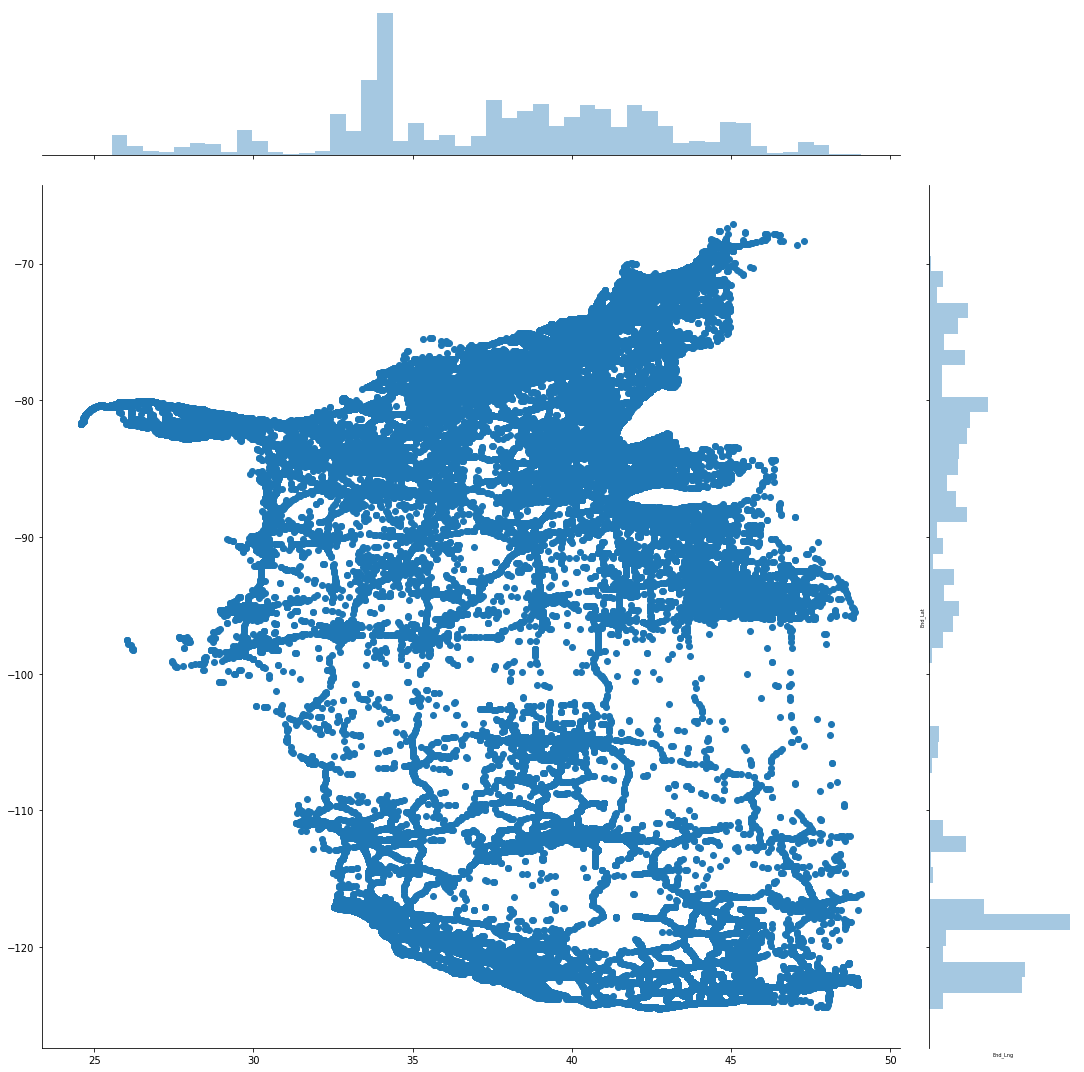

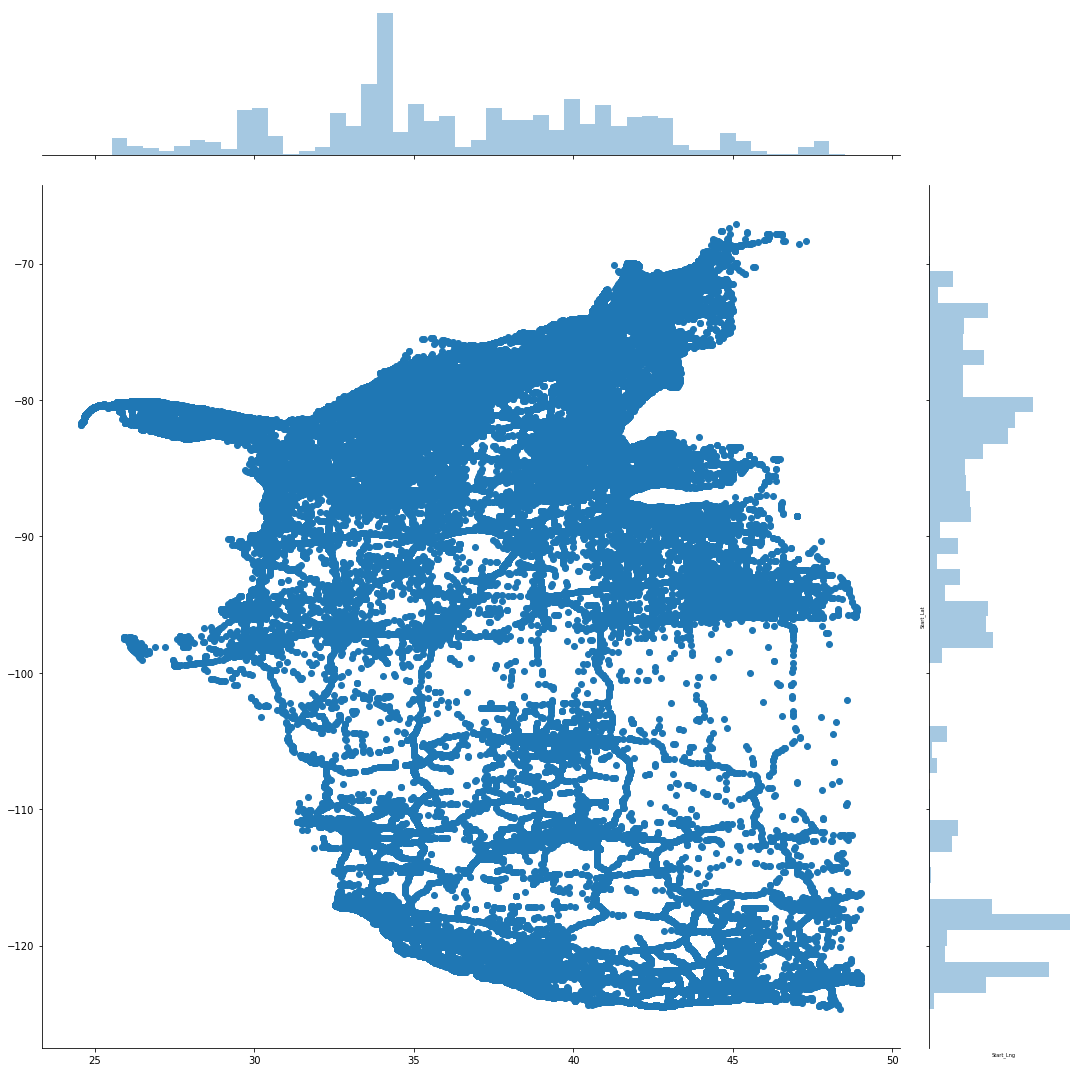

In [0]:
# End Latitude and Longitude 
sns.jointplot(x=df.End_Lat.values,y=df.End_Lng.values,height=15)
plt.ylabel('End_Lat', fontsize=5)
plt.xlabel('End_Lng', fontsize=5)
plt.show()
#Start Latitude and Logitude
sns.jointplot(x=df.Start_Lat.values,y=df.Start_Lng.values,height=15)
plt.ylabel('Start_Lat', fontsize=5)
plt.xlabel('Start_Lng', fontsize=5)
plt.show()

The Plot shows the distribution of accidents across the US Lat/Long Scale. We can observe that most of the occurances are in the West Coast Area.

#### Accident Severity vs Timestamp

Text(0, 0.5, '# Of ACCIDENTS')

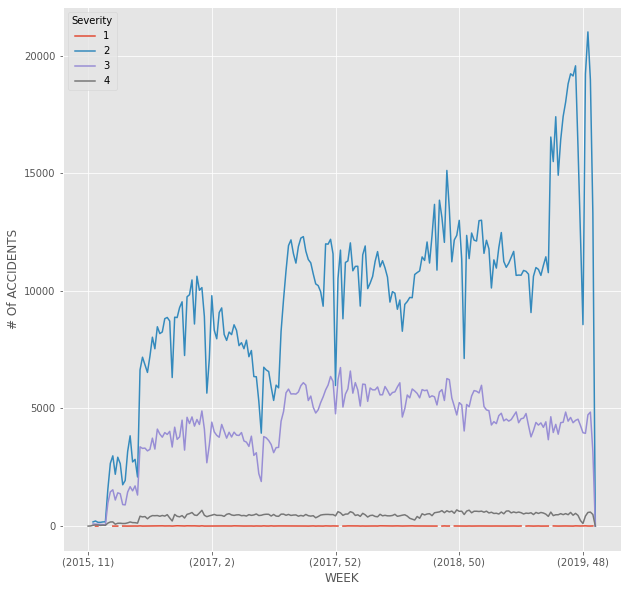

In [0]:
# When did all these accidents happen 
# Add [new columns by extracing from start time 
df['date'] = df['Start_Time'].str.split(n=1).str[0]
df['Date'] = pd.to_datetime(df['date'], errors = 'coerce')
df['Week'] = df['Date'].dt.week
df['Year'] = df['Date'].dt.year
# year, group and severity 
plt.style.use('ggplot')
f, a = plt.subplots(figsize = (10,10))
df.groupby(['Year', 'Week','Severity']).count()['ID'].unstack().plot(ax = a)
a.set_xlabel('WEEK')
a.set_ylabel('# Of ACCIDENTS')

#### Time of accidents

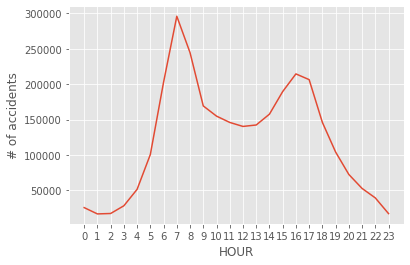

In [0]:
# What time did these accidents happen
df['timestamp'] = pd.to_datetime(df['Weather_Timestamp'], errors='coerce')
df['Hour'] = df['timestamp'] .dt.hour
df['Minute'] = df['timestamp'] .dt.minute
hours = [hour for hour, df in df.groupby('Hour')]
plt.plot(hours, df.groupby(['Hour'])['ID'].count())
plt.xticks(hours)
plt.xlabel('HOUR')
plt.ylabel('# of accidents')
plt.grid(True)
plt.show()

#### Bar plot - Accident Durations

Top 15 longest accidents correspond to 84.6% of the data


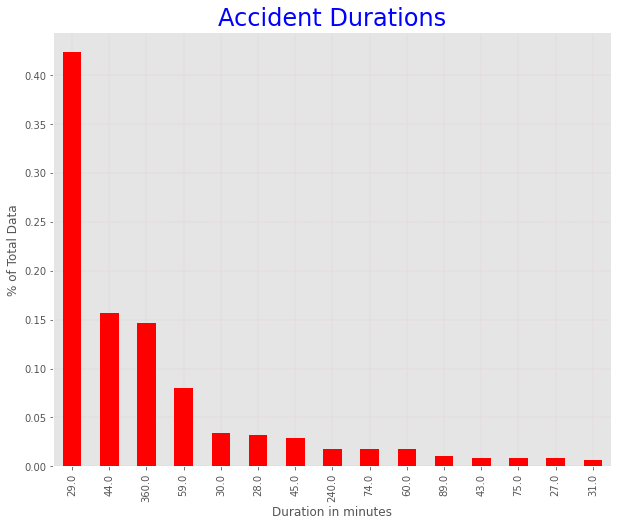

In [0]:
# Top 15 Accident durations

start = pd.to_datetime(df.Start_Time, format='%Y-%m-%d %H:%M:%S')
end = pd.to_datetime(df.End_Time, format='%Y-%m-%d %H:%M:%S')
laps=end-start

top_15 = laps.astype('timedelta64[m]').value_counts().nlargest(15) #Return the first n rows ordered by columns in descending order.
print('Top 15 longest accidents correspond to {:.1f}% of the data'.format(top_15.sum()*100/len(laps)))
(top_15/top_15.sum()).plot.bar(figsize=(10,8), color = 'red')
plt.title('Accident Durations', fontsize = 24, color='blue')
plt.xlabel('Duration in minutes')
plt.ylabel('% of Total Data')
plt.grid(linestyle=':', linewidth = '0.2', color ='salmon');

We can observe from the above plot that around 45% of the accidents are happening for a duration of 29 minutes. That is, most of the accidents take a duration of around half an hour from the time where the accident has started and and after the consequences, the traffic was cleared and to get back to the norm. However, we could also see that there are around 14% of the accidents which take around 6 hours to get the stituation to norm.

#### Bar plot - Accident Rates

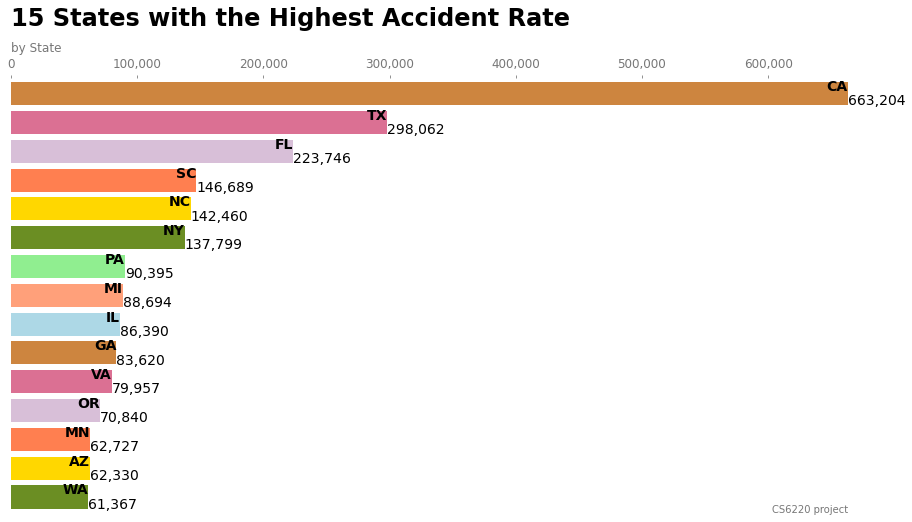

In [0]:
# Accident Rates

df_st = df.groupby('State').size().to_frame('Counts')
df_st = df_st.reset_index().sort_values('Counts', ascending = False)[:15]
df_st = df_st[::-1]   # flip values from top to bottom

colors = ['olivedrab', 'gold', 'coral', 'thistle',
     'palevioletred', 'peru', 'lightblue', 'lightsalmon', 'lightgreen']

fig, ax=plt.subplots(figsize=(15,8))
ax.barh(df_st['State'], df_st['Counts'], color = colors)

for i, (value, name) in enumerate(zip(df_st['Counts'], df_st['State'])):
        ax.text(value, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value, i-.25,     f'{value:,.0f}',  size=14, ha='left',  va='center')
        
ax.text(0, 1.06, 'by State', transform=ax.transAxes, size=12, color='#777777')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.set_yticks([])
ax.margins(0, 0.01)
ax.grid(which='major', axis='x', linestyle='-')
ax.set_axisbelow(True)
ax.text(0, 1.12, '15 States with the Highest Accident Rate', transform=ax.transAxes, size=24, weight=600, ha='left')
ax.text(1, 0, 'CS6220 project', transform=ax.transAxes, ha='right', color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
plt.box(False)


From the above plot we could observe that California has the highest Accident rate followed by Texas and Florida. Moreover, California has about double the cases than the next highest - Texas. 

#### Accident count vs Timezone

Text(0.5, 0, 'Numer of accidents')

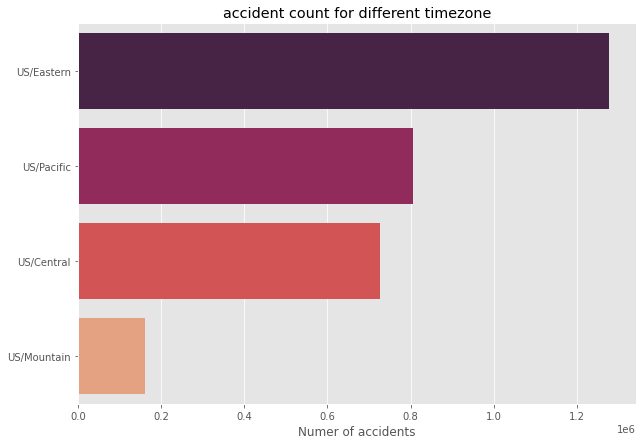

In [0]:
# Accident counts w.r.t timezones

plt.figure(figsize=(10,7))
by_cat = df.groupby(["Timezone"]).size().sort_values(ascending = False)
sns.barplot(by_cat.values, by_cat.index.values, palette = "rocket")
plt.title("accident count for different timezone")
plt.xlabel("Numer of accidents")

We could observe from the above plot that most of the accidents are happening around the Eastern regions followed by the Pacific zone. The Central and Pacific zones are almost comparable considering the number of accidents which took place.

#### Point plot - Hour of day vs TMC 

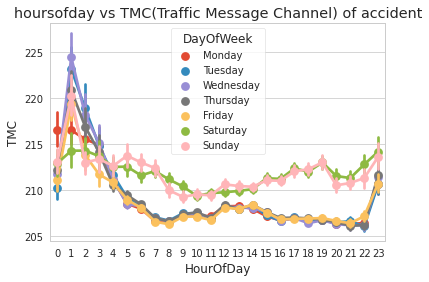

In [0]:
# Traffic Message Channel (TMC) vs hours of day

df['Start_Time'] = pd.to_datetime(df['Start_Time'], format="%Y/%m/%d %H:%M:%S")
df['DayOfWeekNum'] = df['Start_Time'].dt.dayofweek
df['DayOfWeek'] = df['Start_Time'].dt.day_name()
df['MonthDayNum'] = df['Start_Time'].dt.day
df['HourOfDay'] = df['Start_Time'].dt.hour

sns.set_style('whitegrid')
ax = sns.pointplot(x="HourOfDay", y="TMC", hue="DayOfWeek", data=df)
ax.set_title('hoursofday vs TMC(Traffic Message Channel) of accident')
plt.show()

We could observe that around 1 AM most of the TMC codes are in between 215 to 225 which indicates the queing of traffic. The codes around 210 are as follows - 

* 208 - vehicles slowing to look at (Q) accident(s)
* 209 - accident(s) in the opposing lanes	
* 210 - (Q) shed load(s)
* 211 - (Q) broken down vehicle(s)
* 212 - (Q) broken down heavy lorr(y/ies)	

Usually between 7AM to 2PM, most of these codes are prevalent across all the weekdays. 


#### Accidents by Weekday

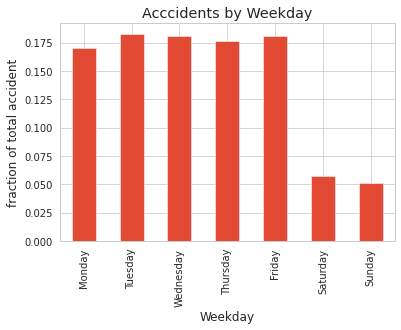

In [0]:
# Accidents by weekday

weekday = df.groupby('DayOfWeek').ID.count()
weekday = weekday/weekday.sum()
dayOfWeek=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday[dayOfWeek].plot.bar()
plt.title('Acccidents by Weekday')
plt.xlabel('Weekday')
plt.ylabel('fraction of total accident');

We could observe from the above plot that on the weekends - Saturday and Sunday, there are not many accidents happening. However on the other weekdays, the accidents are almost uniform.

#### Pie plot - Day vs Night 

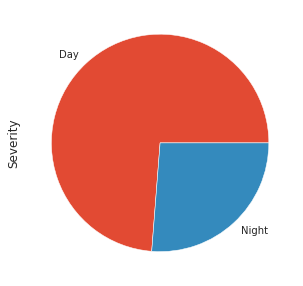

In [0]:
# Accidents Day vs Night

plt.figure(figsize =(10,5))
df.groupby(['Sunrise_Sunset'])['Severity'].size().sort_values(ascending=False).plot.pie()

As we could see from the above plot that most of the accidents are happening over the day time.

In [0]:
# Accidents by time frame setting new keys.
df['Start_Time']= pd.to_datetime(df['Start_Time'])
df['hour']= df['Start_Time'].dt.hour
df['year']= df['Start_Time'].dt.year
df['month']= df['Start_Time'].dt.month
df['week']= df['Start_Time'].dt.week
df['day']= df['Start_Time'].dt.day_name()
df['quarter']= df['Start_Time'].dt.quarter
df['time_zone']= df['Start_Time'].dt.tz
df['time']= df['Start_Time'].dt.time


#### Accidents by Year

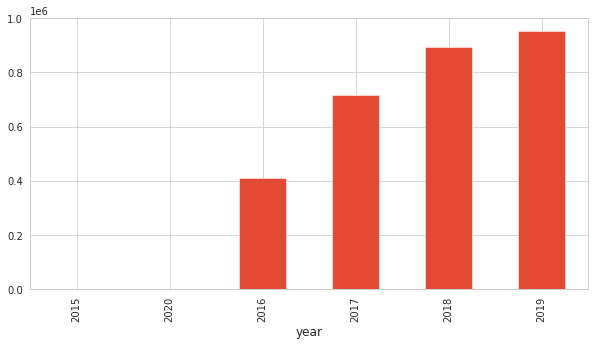

In [0]:
# Accidents by year

plt.figure(figsize =(10,5))
df.groupby(['year']).size().sort_values(ascending=True).plot.bar()

We could see from the above plot that the number of accidents are increasing over the years.

#### Accidents by Month

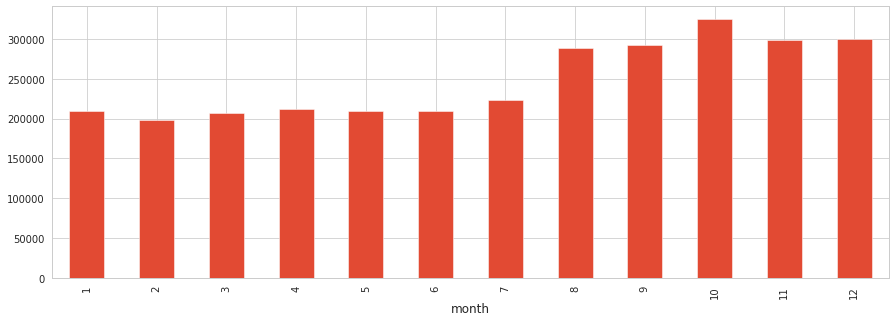

In [0]:
# Accidents by month.

plt.figure(figsize =(15,5))
df.groupby(['month']).size().plot.bar()

We can see that most of the accidents are occuring during the second half of the year. Mainly from August to December, highest being in October.

#### Accidents by the Hour of the day

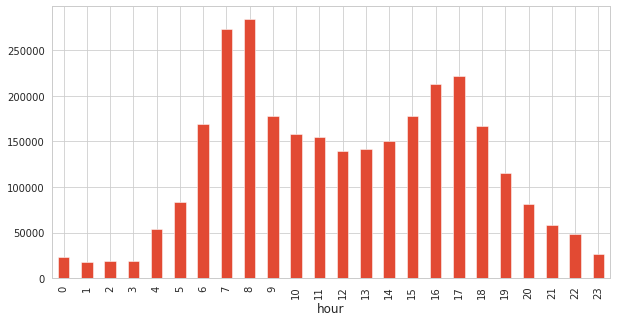

In [0]:
# Accidents by hour of the day.

plt.figure(figsize =(10,5))
df.groupby(['hour']).size().plot.bar()

We could observe from the above plot that most of the accidents happen around 7-8AM. As expected, over the midnight from 11PM to 3AM, there are not many accidents happening. The minor peak of accidents also occur around 4-5PM. This is consistent with peak traffic being during morning (6-9) office/school going hours and afternoon (4-5) Office leaving hours.

#### Accidents by Dayzone

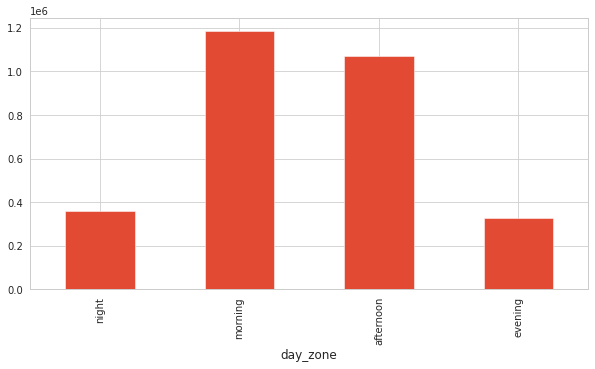

In [0]:
# Accidents by day zone.

df['day_zone'] = pd.cut((df['hour']),bins=(0,6,12,18,24), labels=["night", "morning", "afternoon", "evening"])
plt.figure(figsize =(10,5))
df.groupby(['day_zone']).size().plot.bar()


We can observe that most of the accidents are happening in the morning time.

In [0]:
# Weather conditions cleaning

weatherdata = df['Weather_Condition'].dropna()

def processText(text):
    try:
        textlist = text.split('/')
        for i in range(len(textlist)):
            textlist[i]=textlist[i].split(' ')
            if '' in textlist[i]:
                textlist[i].remove('')
            textlist[i] = ''.join(textlist[i])
        text = '/'.join(textlist)
        return text
    except Exception as e:
        print(text)
        print(e)
        
weatherdata = weatherdata.apply(processText)
weatherdata.head()

0       LightRain
1       LightRain
2        Overcast
3    MostlyCloudy
4    MostlyCloudy
Name: Weather_Condition, dtype: object

In [0]:
weather = weatherdata.groupby(weatherdata).size().reset_index(name='Count').set_index('Weather_Condition').sort_values(by='Count',ascending=False)
top_10_conditions = weather.head(n=10)

# Displaying Values for top 10 weather conditions.
top_10_conditions 

,Count
Weather_Condition,
Clear,808171
MostlyCloudy,412528
Overcast,382480
Fair,335289
PartlyCloudy,295439
ScatteredClouds,204662
LightRain,141073
Cloudy,115496
LightSnow,42123


#### Top 10 Weather conditions

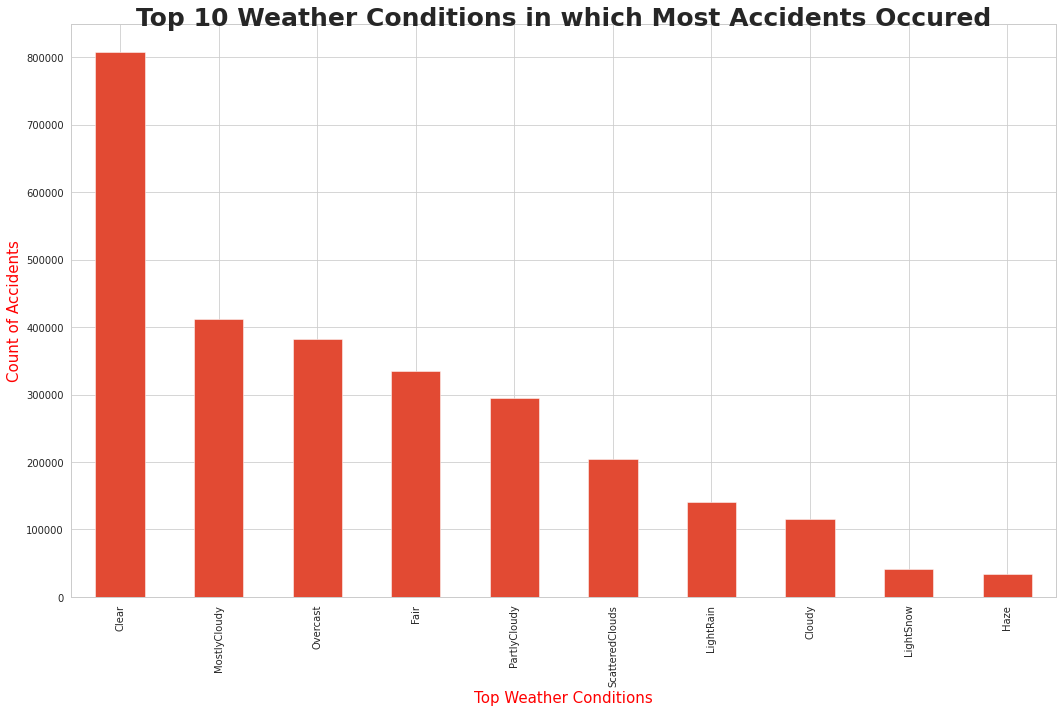

In [0]:
# Plot weather conditions vs Count

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
top_10_conditions.plot.bar(ax=ax)

ax.set_xlabel('Top Weather Conditions',fontsize=15,color='red')
ax.set_ylabel('Count of Accidents',fontsize=15,color='red')
ax.set_title('Top 10 Weather Conditions in which Most Accidents Occured',fontdict={'fontsize': 25, 'fontweight' : 'bold', 'verticalalignment': 'center', 'horizontalalignment': 'center'})
ax.legend().remove()
plt.tight_layout()
plt.show()


We could observe from the above plot that the majority of the accidents are happening when the weather is Clear. We could infer that weather is not much impacting the accidents. Also it could indicate tendency to drive safer when the weather isn't clear as compared otherwise. However, the under the Overcast and Mostly Cloudy conditions, there are a big chunk of accidents.


In [0]:
# Visualizations with boolean columns

bool_cols = [col for col in df.columns if df[col].dtype ==np.dtype('bool')]
booldf = df[bool_cols]
not_one_hot = booldf[booldf.sum(axis=1) > 1]
bools = booldf.sum(axis=0)
bools

Amenity             35220
Bump                  454
Crossing           207590
Give_Way             7627
Junction           238447
No_Exit              3395
Railway             25161
Roundabout            168
Station             56413
Stop                40160
Traffic_Calming      1111
Traffic_Signal     503383
Turning_Loop            0
dtype: int64

#### Pie Plot - Proximity to traffic object

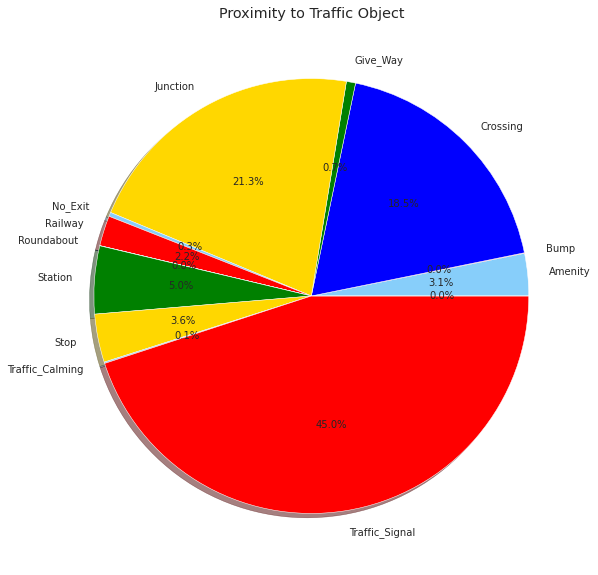

In [0]:
# Plotting booleans in a pie.

bools.plot.pie(autopct='%1.1f%%',
               shadow=True,
               figsize=(10,10), 
               colors = ['lightskyblue', 'red', 'blue', 'green', 'gold'],
               )
plt.ylabel('')
plt.title('Proximity to Traffic Object');


We could observe that Traffic signals, Junctions and Crossings are the traffic objects near which most accidents are occuring.

#### Accident zones - Bar graph

Text(0.5, 1.0, 'count of accidents per zone')

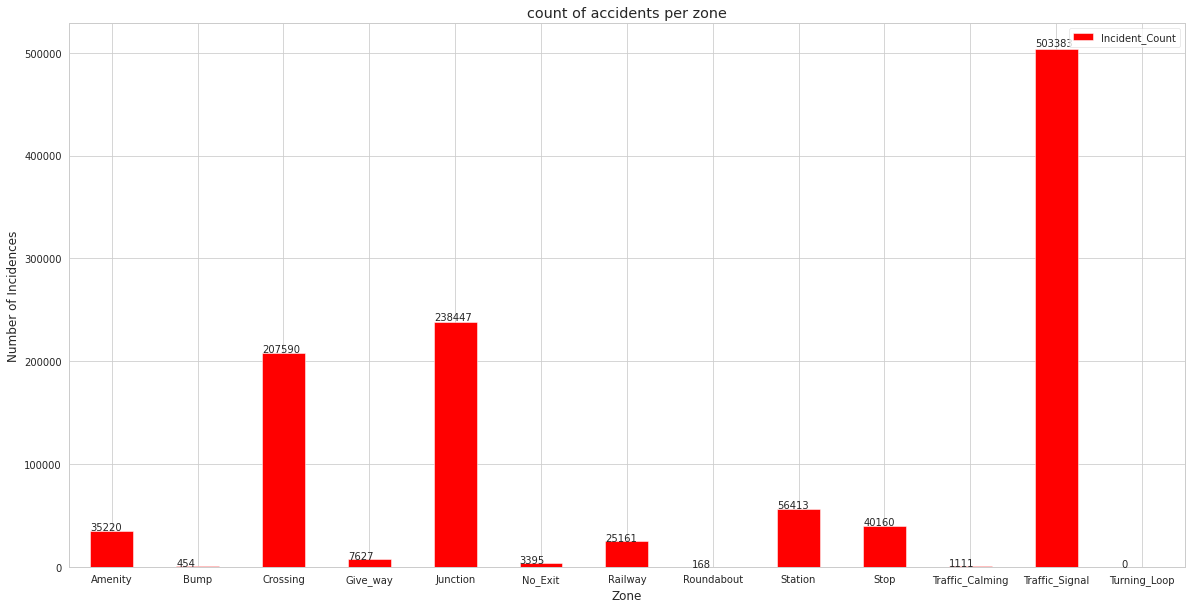

In [0]:
# Plot stats for accident zones 
ax = INCTable.plot.bar(x='Zone', y='Incident_Count', rot=0, figsize=(20,10), color = ['r']);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0005, p.get_height() * 1.005));
ax.set_xlabel('Zone')
ax.set_ylabel('Number of Incidences')
ax.set_title('count of accidents per zone')

#### Accidents by state Map

In [0]:
# Accidents by state map.

df_st_ct = pd.value_counts(df['State'])

fig = go.Figure(data=go.Choropleth(
    locations=df_st_ct.index,
    z = df_st_ct.values.astype(float),  # Data to be color-coded
    locationmode = 'USA-states',     # set of locations match entries in `locations`
    colorscale = 'YlOrRd',
    colorbar_title = "Count",
))

fig.update_layout(
    title_text = 'US Accidents by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### Association Rules

In [0]:
# Transforms boolean columns to values representing their key. +Value mean it was True, REDACTED means it was False
# E.g.:
# Roundabout | => Roundabout
# True       | => +Roundabout
def transform_columns(dataframe, columns):
    new_df = dataframe
    for column in columns:
        new_df[[column]] = new_df[[column]].applymap(lambda x: '+' + column if x else 'REDACTED')
    
    return new_df

In [0]:
# Select MA data and perform some preproccing of data by removing columns we don't care about
# Next transform boolean columns into string representations
ma_dataset_copy = ma_dataset.copy()
ma_dataset_copy.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
194262,A-194264,MapQuest,201.0,2,2016-11-30 15:37:19,2016-11-30 17:08:21,42.144863,-72.599976,NaN,NaN,0.00,Accident on Fairview Ave at Bell St.,98.0,Fairview Ave,R,Chicopee,Hampden,MA,01013-2924,US,US/Eastern,KCEF,2016-11-30 15:51:00,48.2,NaN,100.0,29.87,3.0,Variable,3.5,NaN,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
194266,A-194268,MapQuest,201.0,2,2016-11-30 16:14:24,2016-11-30 17:28:48,42.304436,-71.325317,NaN,NaN,0.00,Accident and fallen power cables on Overbrook ...,NaN,Overbrook Dr,R,Wellesley,Norfolk,MA,02482,US,US/Eastern,KOWD,2016-11-30 16:27:00,48.0,NaN,89.0,29.96,5.0,ENE,5.8,0.05,Rain,False,False,False,False,False,False,False,False,True,False,False,True,False,Night,Day,Day,Day
194267,A-194269,MapQuest,201.0,3,2016-11-30 16:02:41,2016-11-30 17:25:00,42.428036,-71.258476,NaN,NaN,0.01,Left &amp; Right lane blocked due to accident ...,NaN,I-95 N,R,Lexington,Middlesex,MA,02421,US,US/Eastern,KBED,2016-11-30 15:56:00,46.9,NaN,86.0,30.01,5.0,ENE,6.9,0.08,Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
194268,A-194270,MapQuest,200.0,4,2016-11-30 14:12:49,2016-11-30 17:25:00,42.495930,-71.178238,NaN,NaN,0.01,Delays and All lanes except breakdown lane blo...,NaN,MA-128 S,R,Burlington,Middlesex,MA,01803,US,US/Eastern,KBED,2016-11-30 13:56:00,46.0,41.9,89.0,30.01,3.0,East,8.1,0.01,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
194269,A-194271,MapQuest,201.0,3,2016-11-30 16:00:47,2016-11-30 17:15:31,42.525875,-70.972115,NaN,NaN,0.01,Left lane blocked due to accident on I-95 Sout...,NaN,Yankee Division Hwy S,R,Peabody,Essex,MA,01960,US,US/Eastern,KBVY,2016-11-30 15:53:00,46.0,41.9,100.0,29.97,6.0,NNE,8.1,0.07,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [0]:
ma_dataset_copy = ma_dataset_copy.drop(columns=['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Zipcode',
                                 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Timezone',
                                 'Weather_Timestamp', 'Description', 'Number', 'Street', 'Side',
                                 'Country', 'Airport_Code','Civil_Twilight', 'Nautical_Twilight', 
                                 'Astronomical_Twilight', 'TMC', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
                                 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
                                 'City'
                                ])

In [0]:
ma_dataset_copy = ma_dataset_copy.dropna()

In [0]:
ma_dataset_copy = transform_columns(ma_dataset_copy, ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                                       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
                                       'Traffic_Signal', 'Turning_Loop'])
ma_dataset_copy.head()

,Severity,County,State,Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
194262,2,Hampden,MA,Variable,Light Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Day
194266,2,Norfolk,MA,ENE,Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,+Station,REDACTED,REDACTED,+Traffic_Signal,REDACTED,Night
194267,3,Middlesex,MA,ENE,Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Day
194268,4,Middlesex,MA,East,Light Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Day
194269,3,Essex,MA,NNE,Light Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Day


In [0]:
# Select the middlesex county
ma_middlesex_county = ma_dataset_copy[ma_dataset_copy['County'] == 'Middlesex']
ma_middlesex_county = ma_middlesex_county.drop(columns=['County', 'State', 'Wind_Direction'])
ma_middlesex_county.head()

,Severity,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
194267,3,Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Day
194268,4,Light Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Day
194275,3,Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Night
194291,2,Light Rain,REDACTED,REDACTED,+Crossing,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,+Station,REDACTED,REDACTED,+Traffic_Signal,REDACTED,Night
194292,3,Rain,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,REDACTED,Night


In [0]:
# (c) 2016 Everaldo Aguiar & Reid Johnson
#
# Modified from:
# Marcel Caraciolo (https://gist.github.com/marcelcaraciolo/1423287)
#
# Functions to compute and extract association rules from a given frequent itemset 
# generated by the Apriori algorithm.
#
# The Apriori algorithm is defined by Agrawal and Srikant in:
# Fast algorithms for mining association rules
# Proc. 20th int. conf. very large data bases, VLDB. Vol. 1215. 1994

def to_array(dataframe, stop_word=",REDACTED"):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''
    rows = dataframe.to_csv(header=False, index=False).split('\n')
    return [row.replace(stop_word, "").split(",") for row in rows if len(row) > 0]

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = list(map(set, dataset))
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

In [0]:
dataset = to_array(ma_middlesex_county)
D = list(map(set, dataset))
D[0]

{'3', 'Day', 'Rain'}

#### Support Analysis

* We preprocessed the data by focusing on the severity, weather, day/night and our boolean attributes that were true. We did this because
these values were sparser and allowed to determine if there were any correlations between severities and the presence of
of these attributes. The most interesting to note for the support rules is that there is a strong support between severity 3 and day time.
{Day, 3}:  sup = 0.333. Another interesting thing we notice is that if there is a traffic signal the severity of the accident is less, i.e. {2, +Traffic_Signal}:  sup = 0.108.

In [0]:
# apriori to generate support rules, i.e. how often it occurs
freq_items = apriori(D, min_support=0.02, verbose=True)

{Cloudy}:  sup = 0.036
{Fair}:  sup = 0.074
{Light Snow}:  sup = 0.023
{Partly Cloudy}:  sup = 0.095
{Clear}:  sup = 0.24
{Scattered Clouds}:  sup = 0.093
{+Junction}:  sup = 0.144
{Mostly Cloudy}:  sup = 0.145
{Overcast}:  sup = 0.165
{2}:  sup = 0.572
{+Traffic_Signal}:  sup = 0.12
{+Station}:  sup = 0.058
{+Crossing}:  sup = 0.056
{Night}:  sup = 0.203
{Light Rain}:  sup = 0.074
{Day}:  sup = 0.797
{3}:  sup = 0.424
{Fair, 3}:  sup = 0.034
{Fair, Day}:  sup = 0.06
{Day, Cloudy}:  sup = 0.028
{2, Cloudy}:  sup = 0.021
{Fair, 2}:  sup = 0.039
{Clear, +Traffic_Signal}:  sup = 0.02
{3, Light Rain}:  sup = 0.028
{3, Partly Cloudy}:  sup = 0.038
{Overcast, +Junction}:  sup = 0.025
{Day, Overcast}:  sup = 0.122
{3, Overcast}:  sup = 0.069
{Night, +Junction}:  sup = 0.031
{Day, +Station}:  sup = 0.048
{Day, +Crossing}:  sup = 0.048
{Day, +Traffic_Signal}:  sup = 0.099
{2, Mostly Cloudy}:  sup = 0.082
{Day, Partly Cloudy}:  sup = 0.08
{Partly Cloudy, 2}:  sup = 0.056
{Scattered Clouds, 3}:  

#### Confidence Analysis

 * Now looking at the confidence rules, we notice there is strong confidence between junction (like a roundabout) and night time, and the severity {+Junction, Night} ---> {3}:  conf = 0.653, sup = 0.021. What is also interesting to observe is that there is a high confidence during the day as well, {+Junction, Day} ---> {3}:  conf = 0.613, sup = 0.069. Also we can observe that there is a correlation between a traffic signal and the severity of the accident by looking at this rule {Day, +Traffic_Signal} ---> {2}:  conf = 0.901, sup = 0.09. Also if we can observe if there is a crosswalk the accident is less severe {+Crossing, Day} ---> {2}:  conf = 0.85, sup = 0.041.

In [0]:
# Generate our confidence rules, i.e. how true it is
confidence_rules = generate_rules(
    freq_items[0], 
    freq_items[1], 
    min_confidence=0.5,
    verbose=True
)

{Fair} ---> {Day}:  conf = 0.819, sup = 0.06
{Cloudy} ---> {Day}:  conf = 0.779, sup = 0.028
{Cloudy} ---> {2}:  conf = 0.59, sup = 0.021
{Fair} ---> {2}:  conf = 0.53, sup = 0.039
{Overcast} ---> {Day}:  conf = 0.737, sup = 0.122
{+Station} ---> {Day}:  conf = 0.833, sup = 0.048
{+Crossing} ---> {Day}:  conf = 0.849, sup = 0.048
{+Traffic_Signal} ---> {Day}:  conf = 0.826, sup = 0.099
{Mostly Cloudy} ---> {2}:  conf = 0.565, sup = 0.082
{Partly Cloudy} ---> {Day}:  conf = 0.842, sup = 0.08
{Partly Cloudy} ---> {2}:  conf = 0.592, sup = 0.056
{Clear} ---> {Day}:  conf = 0.778, sup = 0.187
{Clear} ---> {2}:  conf = 0.558, sup = 0.134
{2} ---> {Day}:  conf = 0.804, sup = 0.46
{Day} ---> {2}:  conf = 0.576, sup = 0.46
{Scattered Clouds} ---> {Day}:  conf = 0.865, sup = 0.08
{Scattered Clouds} ---> {2}:  conf = 0.575, sup = 0.053
{+Junction} ---> {3}:  conf = 0.622, sup = 0.089
{+Junction} ---> {Day}:  conf = 0.781, sup = 0.112
{Mostly Cloudy} ---> {Day}:  conf = 0.87, sup = 0.127
{Overcas

### ML Models

Importing ML specific libraries

In [0]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Import GaussianNB
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

#### Cleaning for ML **models**

Extract Year, Month, Day, hour and weekday from the datetime and create new columns. Added the time duration as well.

In [0]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Data columns (total 73 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               int64         
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [0]:
# Dealing with outliers
# A. Drop rows with negative time duration

# Check if there is any negative time_duration values
df[td][df[td]<=0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
628436    -12.0
628472    -31.0
628489     -0.0
628923    -14.0
628942     -0.0
628943    -30.0
1265261   -30.0
1265262   -31.0
2002026   -30.0
2002111   -30.0
2002112   -31.0
2565229   -34.0
2565705    -7.0
2565708    -7.0
2693474   -31.0
Name: Time_Duration(min), dtype: float64

Dropping the rows with negative time duration to clean up the dataset.

In [0]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974313 entries, 0 to 2974334
Data columns (total 73 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [0]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

Fill out the outliers with median values.

In [0]:
# B. Fill outliers with median values

# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974313 entries, 0 to 2974334
Data columns (total 73 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

The following are the list of features used for the ML models.

In [0]:
# Set the list of features to include in Machine Learning
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

Select the dataset to have only the above selected features.

In [0]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974313 entries, 0 to 2974334
Data columns (total 34 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Source              object 
 1   TMC                 float64
 2   Severity            float64
 3   Start_Lng           float64
 4   Start_Lat           float64
 5   Distance(mi)        float64
 6   Side                object 
 7   City                object 
 8   County              object 
 9   State               object 
 10  Timezone            object 
 11  Temperature(F)      float64
 12  Humidity(%)         float64
 13  Pressure(in)        float64
 14  Visibility(mi)      float64
 15  Wind_Direction      object 
 16  Weather_Condition   object 
 17  Amenity             float64
 18  Bump                float64
 19  Crossing            float64
 20  Give_Way            float64
 21  Junction            float64
 22  No_Exit             float64
 23  Railway             float64
 24  Roundabout          floa

Out of the original 48 features, we have selected 33 by removing the boolean type columns. Using those features, we would estimate the Severity of the accident.

In [0]:
# Check missing values
df_sel.isnull().mean()

Source                0.000196
TMC                   0.244799
Severity              0.000196
Start_Lng             0.000196
Start_Lat             0.000196
Distance(mi)          0.000196
Side                  0.000196
City                  0.000224
County                0.000196
State                 0.000196
Timezone              0.001259
Temperature(F)        0.019033
Humidity(%)           0.020079
Pressure(in)          0.016372
Visibility(mi)        0.022271
Wind_Direction        0.015352
Weather_Condition     0.022353
Amenity               0.000196
Bump                  0.000196
Crossing              0.000196
Give_Way              0.000196
Junction              0.000196
No_Exit               0.000196
Railway               0.000196
Roundabout            0.000196
Station               0.000196
Stop                  0.000196
Traffic_Calming       0.000196
Traffic_Signal        0.000196
Turning_Loop          0.000196
Sunrise_Sunset        0.000227
Hour                  0.000196
Weekday 

The below is the subset of dataset with the selected features used for training the models.

In [0]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(2181347, 34)

**Select Texas as the first State of interest.**

In [0]:
# Select state of interest 
# Set state
state1='TX'

# Select the state of Mass
df_state_TX=df_sel.loc[df_sel.State==state1].copy()
df_state_TX.drop('State',axis=1, inplace=True)
df_state_TX.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 251306 entries, 261007 to 2245839
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Source              251306 non-null  object 
 1   TMC                 251306 non-null  float64
 2   Severity            251306 non-null  float64
 3   Start_Lng           251306 non-null  float64
 4   Start_Lat           251306 non-null  float64
 5   Distance(mi)        251306 non-null  float64
 6   Side                251306 non-null  object 
 7   City                251306 non-null  object 
 8   County              251306 non-null  object 
 9   Timezone            251306 non-null  object 
 10  Temperature(F)      251306 non-null  float64
 11  Humidity(%)         251306 non-null  float64
 12  Pressure(in)        251306 non-null  float64
 13  Visibility(mi)      251306 non-null  float64
 14  Wind_Direction      251306 non-null  object 
 15  Weather_Condition   251306 n

**Select Massachussetts as the second State of interest.**

In [0]:
state2='MA'

# Select the state of Mass
df_state_MA=df_sel.loc[df_sel.State==state2].copy()
df_state_MA.drop('State',axis=1, inplace=True)
df_state_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27228 entries, 194262 to 2244029
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              27228 non-null  object 
 1   TMC                 27228 non-null  float64
 2   Severity            27228 non-null  float64
 3   Start_Lng           27228 non-null  float64
 4   Start_Lat           27228 non-null  float64
 5   Distance(mi)        27228 non-null  float64
 6   Side                27228 non-null  object 
 7   City                27228 non-null  object 
 8   County              27228 non-null  object 
 9   Timezone            27228 non-null  object 
 10  Temperature(F)      27228 non-null  float64
 11  Humidity(%)         27228 non-null  float64
 12  Pressure(in)        27228 non-null  float64
 13  Visibility(mi)      27228 non-null  float64
 14  Wind_Direction      27228 non-null  object 
 15  Weather_Condition   27228 non-null  object 
 1

**Map of accidents - Texas**

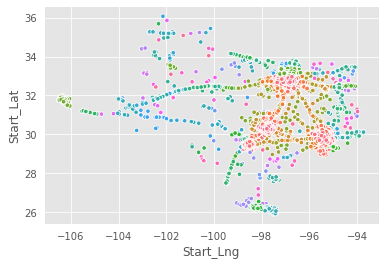

In [0]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state_TX, hue='County', legend=False, s=20)
plt.show()

**Map of accidents - Massachusetts**

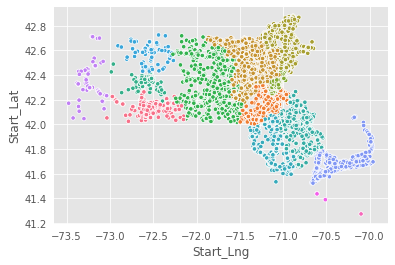

In [0]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state_MA, hue='County', legend=False, s=20)
plt.show()

**Set the first county as Dallas in Texas.**

In [0]:
# Set the first county
county1='Dallas'

# Select the state of Texas, Dallas County
df_county_TX=df_state_TX.loc[df_state_TX.County==county1].copy()
df_county_TX.drop('County',axis=1, inplace=True)
df_county_TX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54619 entries, 261012 to 2245513
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              54619 non-null  object 
 1   TMC                 54619 non-null  float64
 2   Severity            54619 non-null  float64
 3   Start_Lng           54619 non-null  float64
 4   Start_Lat           54619 non-null  float64
 5   Distance(mi)        54619 non-null  float64
 6   Side                54619 non-null  object 
 7   City                54619 non-null  object 
 8   Timezone            54619 non-null  object 
 9   Temperature(F)      54619 non-null  float64
 10  Humidity(%)         54619 non-null  float64
 11  Pressure(in)        54619 non-null  float64
 12  Visibility(mi)      54619 non-null  float64
 13  Wind_Direction      54619 non-null  object 
 14  Weather_Condition   54619 non-null  object 
 15  Amenity             54619 non-null  float64
 1

**Set the second county as Middlesex in Massachussetts.**

In [0]:
# Set the second county
county2='Middlesex'

# Select the state of Massachusetts, Middlesex County
df_county_MA=df_state_MA.loc[df_state_MA.County==county2].copy()
df_county_MA.drop('County',axis=1, inplace=True)
df_county_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10577 entries, 194267 to 2243755
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              10577 non-null  object 
 1   TMC                 10577 non-null  float64
 2   Severity            10577 non-null  float64
 3   Start_Lng           10577 non-null  float64
 4   Start_Lat           10577 non-null  float64
 5   Distance(mi)        10577 non-null  float64
 6   Side                10577 non-null  object 
 7   City                10577 non-null  object 
 8   Timezone            10577 non-null  object 
 9   Temperature(F)      10577 non-null  float64
 10  Humidity(%)         10577 non-null  float64
 11  Pressure(in)        10577 non-null  float64
 12  Visibility(mi)      10577 non-null  float64
 13  Wind_Direction      10577 non-null  object 
 14  Weather_Condition   10577 non-null  object 
 15  Amenity             10577 non-null  float64
 1

Generate dummies for both the counties.

In [0]:
# Generate dummies for categorical data
df_county_dummy_TX = pd.get_dummies(df_county_TX,drop_first=True)
df_county_dummy_MA = pd.get_dummies(df_county_MA,drop_first=True)

In [0]:
df_county_dummy_TX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54619 entries, 261012 to 2245513
Columns: 126 entries, TMC to Weekday_Wed
dtypes: float64(24), uint8(102)
memory usage: 15.7 MB


In [0]:
df_county_dummy_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10577 entries, 194267 to 2243755
Columns: 158 entries, TMC to Weekday_Wed
dtypes: float64(24), uint8(134)
memory usage: 3.4 MB


For implementing the supervised learning algorithms, we have created Train and Test data splits with 20% of the data as Test and 80% of Train data for both the states - MA and TX.

In [0]:
# Predict the accident severity with various supervised machine learning algorithm
# Data preparation: train_test_split

# Assign the data
df_TX=df_county_dummy_TX
df_MA=df_county_dummy_MA


# Set the target for the prediction
target='Severity'

# Create arrays for the features and the response variable

# set X and y for Texas
y_TX = df_TX[target]
X_TX = df_TX.drop(target, axis=1)

# Split the data set into training and testing data sets for Texas
X_train_TX, X_test_TX, y_train_TX, y_test_TX = train_test_split(X_TX, y_TX, test_size=0.2, random_state=21, stratify=y_TX)


#########################

# Create arrays for the features and the response variable

# set X and y for Massachussetts
y_MA = df_MA[target]
X_MA = df_MA.drop(target, axis=1)

# Split the data set into training and testing data sets for MA
X_train_MA, X_test_MA, y_train_MA, y_test_MA = train_test_split(X_MA, y_MA, test_size=0.2, random_state=21, stratify=y_MA)



The following the the classification algorithms we chose.


1.   Logistic Regression
2.   K-Nearest Neighbors
3.   Decision Trees
4.   Random Forest
5.   Gaussian Naive Bayes




In [0]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest','Gaussian Naive Bayes']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst_TX=[]

accuracy_lst_MA=[]


**Predict the accident severity with various supervised machine learning algorithms**

#### Logistic regression

In [0]:
# A. Logistic regression

# Logistic regression for Texas
lr = LogisticRegression(random_state=0, max_iter=100, solver='liblinear')
lr.fit(X_train_TX,y_train_TX)
y_pred_TX=lr.predict(X_test_TX)

# Get the accuracy score
acc_TX=accuracy_score(y_test_TX, y_pred_TX)

# Append to the accuracy list
accuracy_lst_TX.append(acc_TX)

print("[Logistic regression algorithm] accuracy_score for Texas: {:.3f}.".format(acc_TX))

[Logistic regression algorithm] accuracy_score for Texas: 0.768.


In [0]:
# Logistic regression for MA
lr = LogisticRegression(random_state=0, max_iter=100, solver='liblinear')
lr.fit(X_train_MA,y_train_MA)
y_pred_MA=lr.predict(X_test_MA)

# Get the accuracy score
acc_MA=accuracy_score(y_test_MA, y_pred_MA)

# Append to the accuracy list
accuracy_lst_MA.append(acc_MA)

print("[Logistic regression algorithm] accuracy_score for MA: {:.3f}.".format(acc_MA))

[Logistic regression algorithm] accuracy_score for MA: 0.838.


We could observe that using Logistic regression, the accuracy score for MA is greater compared to TX.

#### K-Nearest Neighbors 

In [0]:
# B. The K-Nearest Neighbors (KNN) algorithm for TX

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train_TX,y_train_TX)

# Predict the labels for the training data X
y_pred_TX = knn.predict(X_test_TX)

# Get the accuracy score
acc_TX=accuracy_score(y_test_TX, y_pred_TX)

# Append to the accuracy list
accuracy_lst_TX.append(acc_TX)

print('[K-Nearest Neighbors (KNN)] knn.score for TX: {:.3f}.'.format(knn.score(X_test_TX, y_test_TX)))
print('[K-Nearest Neighbors (KNN)] accuracy_score for TX: {:.3f}.'.format(acc_TX))

[K-Nearest Neighbors (KNN)] knn.score for TX: 0.683.
[K-Nearest Neighbors (KNN)] accuracy_score for TX: 0.683.


In [0]:
# The K-Nearest Neighbors (KNN) algorithm for MA

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train_MA,y_train_MA)

# Predict the labels for the training data X
y_pred_MA = knn.predict(X_test_MA)

# Get the accuracy score
acc_MA=accuracy_score(y_test_MA, y_pred_MA)

# Append to the accuracy list
accuracy_lst_MA.append(acc_MA)

print('[K-Nearest Neighbors (KNN)] knn.score for MA: {:.3f}.'.format(knn.score(X_test_MA, y_test_MA)))
print('[K-Nearest Neighbors (KNN)] accuracy_score for MA: {:.3f}.'.format(acc_MA))

[K-Nearest Neighbors (KNN)] knn.score for MA: 0.583.
[K-Nearest Neighbors (KNN)] accuracy_score for MA: 0.583.


We could observe that using KNN, the accuracy score for TX is greater compared to MA.

**Optimizing the number of neighbors**

Optimizing the number of neighbors for KNN on the Dallas County dataset by choosing the value of 'k' from 1 to 9.

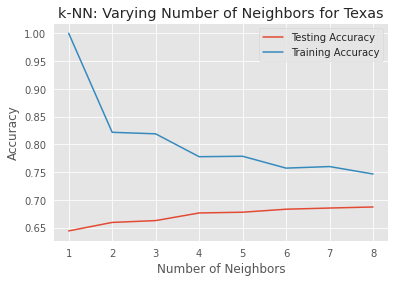

In [0]:
# For TX

# Optmize the number of neighors: plot the accuracy versus number of neighbors

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy_TX = np.empty(len(neighbors))
test_accuracy_TX = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train_TX,y_train_TX)
    
    #Compute accuracy on the training set
    train_accuracy_TX[i] = knn.score(X_train_TX, y_train_TX)

    #Compute accuracy on the testing set
    test_accuracy_TX[i] = knn.score(X_test_TX, y_test_TX)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors for Texas')
plt.plot(neighbors, test_accuracy_TX, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy_TX, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

We could observe from the above plot that the knee point that the ideal number of neighbors is 2 for Texas County.

Optimizing the number of neighbors for KNN on the Middlesex County dataset by choosing the value of 'k' from 1 to 9.

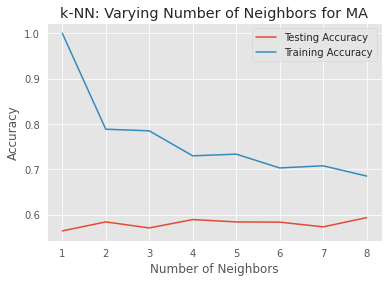

In [0]:
# For MA

# Optmize the number of neighors: plot the accuracy versus number of neighbors

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy_MA = np.empty(len(neighbors))
test_accuracy_MA = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train_MA,y_train_MA)
    
    #Compute accuracy on the training set
    train_accuracy_MA[i] = knn.score(X_train_MA, y_train_MA)

    #Compute accuracy on the testing set
    test_accuracy_MA[i] = knn.score(X_test_MA, y_test_MA)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors for MA')
plt.plot(neighbors, test_accuracy_MA, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy_MA, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

We could observe from the above plot that the knee point that the ideal number of neighbors is 2 for MA County.

#### Decision Tree

Decision Tree algorithm for Dallas County - TX

In [0]:
# C. Decision Tree
 
# Decision tree algorithm for TX

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train_TX, y_train_TX)

# Use dt_entropy to predict test set labels
y_pred_TX= dt_entropy.predict(X_test_TX)

# Evaluate accuracy_entropy
accuracy_entropy_TX = accuracy_score(y_test_TX, y_pred_TX)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score for TX: {:.3f}.'.format(accuracy_entropy_TX))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train_TX, y_train_TX)

# Use dt_entropy to predict test set labels
y_pred_TX= dt_gini.predict(X_test_TX)

# Evaluate accuracy_entropy
accuracy_gini_TX = accuracy_score(y_test_TX, y_pred_TX)

# Append to the accuracy list
acc_TX=accuracy_gini_TX
accuracy_lst_TX.append(acc_TX)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score for TX: {:.3f}.'.format(accuracy_gini_TX))


[Decision Tree -- entropy] accuracy_score for TX: 0.799.
[Decision Tree -- gini] accuracy_score for TX: 0.795.


Decision Tree algorithm for Dallas County - MA

In [0]:
# Decision tree algorithm for MA

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train_MA, y_train_MA)

# Use dt_entropy to predict test set labels
y_pred_MA= dt_entropy.predict(X_test_MA)

# Evaluate accuracy_entropy
accuracy_entropy_MA = accuracy_score(y_test_MA, y_pred_MA)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score for MA: {:.3f}.'.format(accuracy_entropy_MA))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train_MA, y_train_MA)

# Use dt_entropy to predict test set labels
y_pred_MA= dt_gini.predict(X_test_MA)

# Evaluate accuracy_entropy
accuracy_gini_MA = accuracy_score(y_test_MA, y_pred_MA)

# Append to the accuracy list
acc_MA=accuracy_gini_MA
accuracy_lst_MA.append(acc_MA)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score for MA: {:.3f}.'.format(accuracy_gini_MA))


[Decision Tree -- entropy] accuracy_score for MA: 0.781.
[Decision Tree -- gini] accuracy_score for MA: 0.782.


We could observe that the accuracy score for TX is almost comparable to MA using Decision trees. 

#### Random Forest

**Random Forest for Texas.**

In [0]:
# D. Random Forest

# Random Forest algorithm for TX

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_TX,y_train_TX)

y_pred_TX=clf.predict(X_test_TX)


# Get the accuracy score
acc_TX=accuracy_score(y_test_TX, y_pred_TX)

# Append to the accuracy list
accuracy_lst_TX.append(acc_TX)


# Model Accuracy, how often is the classifier correct?
print("[Random forest algorithm] accuracy_score for TX: {:.3f}.".format(acc_TX))


[Random forest algorithm] accuracy_score for TX: 0.859.


**Visualizing the important features**

No handles with labels found to put in legend.


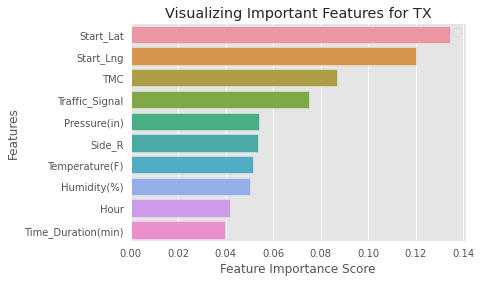

In [0]:
# Visualize important features for TX

feature_imp_TX = pd.Series(clf.feature_importances_,index=X_TX.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp_TX[:10], y=feature_imp_TX.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for TX")
plt.legend()
plt.show()

The below are the top 20 important features based upon the TX Dallas County data.

In [0]:
# List top k important features for TX
k=20
feature_imp_TX.sort_values(ascending=False)[:k]

Start_Lat               0.134146
Start_Lng               0.119971
TMC                     0.086623
Traffic_Signal          0.074852
Pressure(in)            0.053813
Side_R                  0.053352
Temperature(F)          0.051430
Humidity(%)             0.050384
Hour                    0.041748
Time_Duration(min)      0.039835
Crossing                0.026204
City_Irving             0.016160
Visibility(mi)          0.015305
Distance(mi)            0.014120
City_Dallas             0.012962
Junction                0.008741
Sunrise_Sunset_Night    0.007427
City_Mesquite           0.007307
Weekday_Tue             0.007304
Weekday_Wed             0.007136
dtype: float64

In [0]:
# Select the top important features, set the threshold for TX

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train_TX, y_train_TX)

feat_labels=X_TX.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

TMC
Start_Lng
Start_Lat
Temperature(F)
Humidity(%)
Pressure(in)
Traffic_Signal
Hour
Time_Duration(min)
Side_R


In [0]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train_TX = sfm.transform(X_train_TX)
X_important_test_TX = sfm.transform(X_test_TX)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train_TX, y_train_TX)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
# Apply The Full Featured Classifier To The Test Data
y_pred_TX = clf.predict(X_test_TX)

# View The Accuracy Of Our Full Feature Model
print('[Random forest algorithm -- Full feature] on TX accuracy_score: {:.3f}.'.format(accuracy_score(y_test_TX, y_pred_TX)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test_TX)

# View The Accuracy Of Our Limited Feature Model
print('[Random forest algorithm -- Limited feature] on TX accuracy_score: {:.3f}.'.format(accuracy_score(y_test_TX, y_important_pred)))


[Random forest algorithm -- Full feature] on TX accuracy_score: 0.859.
[Random forest algorithm -- Limited feature] on TX accuracy_score: 0.900.


So by selecting limited number of features with threshold greater than 0.03, we could see that the accuracy has been improved by 4%. 

The following are the important features which have been prominenet for the accidents in TX.

*   TMC
*   Start_Lng
*   Start_Lat
*   Temperature(F)
*   Humidity(%)
*   Pressure(in)
*   Traffic_Signal
*   Hour
*   Time_Duration(min)
*   Side_R






**Random forest for MA**

In [0]:
# D. Random Forest

# Random Forest algorithm for MA

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_MA,y_train_MA)

y_pred_MA=clf.predict(X_test_MA)


# Get the accuracy score
acc_MA=accuracy_score(y_test_MA, y_pred_MA)

# Append to the accuracy list
accuracy_lst_MA.append(acc_MA)


# Model Accuracy, how often is the classifier correct?
print("[Random forest algorithm] accuracy_score for MA: {:.3f}.".format(acc_MA))


[Random forest algorithm] accuracy_score for MA: 0.901.


**Visualizing the important features for MA**

No handles with labels found to put in legend.


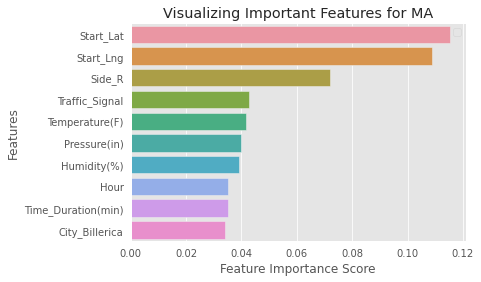

In [0]:
# Visualize important features for MA

feature_imp_MA = pd.Series(clf.feature_importances_,index=X_MA.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp_MA[:10], y=feature_imp_MA.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for MA")
plt.legend()
plt.show()

The below are the top 20 important features based upon the MA Middlesex County data.

In [0]:
# List top k important features for MA
k=20
feature_imp_MA.sort_values(ascending=False)[:k]

Start_Lat               0.115167
Start_Lng               0.108687
Side_R                  0.072124
Traffic_Signal          0.042812
Temperature(F)          0.041740
Pressure(in)            0.039877
Humidity(%)             0.039008
Hour                    0.035179
Time_Duration(min)      0.035068
City_Billerica          0.033884
City_North Billerica    0.023353
Station                 0.020882
TMC                     0.018386
Distance(mi)            0.015785
Junction                0.015222
Visibility(mi)          0.010919
City_Woburn             0.010708
City_Cambridge          0.009552
City_Hopkinton          0.009236
City_Wilmington         0.009053
dtype: float64

In [0]:
# Select the top important features, set the threshold for MA

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train_MA, y_train_MA)

feat_labels=X_MA.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
Temperature(F)
Humidity(%)
Pressure(in)
Traffic_Signal
Hour
Time_Duration(min)
Side_R


In [0]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train_MA = sfm.transform(X_train_MA)
X_important_test_MA = sfm.transform(X_test_MA)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train_MA, y_train_MA)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
# Apply The Full Featured Classifier To The Test Data
y_pred_MA = clf.predict(X_test_MA)

# View The Accuracy Of Our Full Feature Model
print('[Random forest algorithm -- Full feature] on MA accuracy_score: {:.3f}.'.format(accuracy_score(y_test_MA, y_pred_MA)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test_MA)

# View The Accuracy Of Our Limited Feature Model
print('[Random forest algorithm -- Limited feature] on MA accuracy_score: {:.3f}.'.format(accuracy_score(y_test_MA, y_important_pred)))


[Random forest algorithm -- Full feature] on MA accuracy_score: 0.901.
[Random forest algorithm -- Limited feature] on MA accuracy_score: 0.892.


So by selecting limited number of features with threshold greater than 0.03, we could see that the accuracy has been improved by only 0.3%.

The following are the important features which have been prominent for the accidents in MA.

*   Start_Lng
*   Start_Lat
*   Temperature(F)
*   Humidity(%)
*   Pressure(in)
*   Traffic_Signal
*   Hour
*   Time_Duration(min)
*   Side_R
*   City_Billerica


#### Gaussian Naive Bayes

In [0]:
# Gaussian Naive Bayes
gnb = GaussianNB(var_smoothing = 1)

gnb.fit(X_train_TX,y_train_TX)
y_pred_TX = gnb.predict(X_test_TX)

# Get the accuracy score
acc_TX=accuracy_score(y_test_TX, y_pred_TX)

# Append to the accuracy list
accuracy_lst_TX.append(acc_TX)

print("[Gaussian Naive Bayes algorithm] accuracy score for Texas: {:.3f}.".format(acc_TX))

[Gaussian Naive Bayes algorithm] accuracy score for Texas: 0.620.


In [0]:
# F. Gaussian Naive Bayes
gnb = GaussianNB(var_smoothing = 1)

gnb.fit(X_train_MA,y_train_MA)
y_pred_MA = gnb.predict(X_test_MA)

# Get the accuracy score
acc_MA=accuracy_score(y_test_MA, y_pred_MA)

# Append to the accuracy list
accuracy_lst_MA.append(acc_MA)

print("[Gaussian Naive Bayes algorithm] accuracy score for Massachusetts: {:.3f}.".format(acc_MA))

[Gaussian Naive Bayes algorithm] accuracy score for Massachusetts: 0.556.


We could observe that using Gaussian Naive Bayes, the accuracy score for TX is greater compared to MA.

***Accuracy List for Texas***

In [0]:
accuracy_lst_TX

[0.7676675210545588,
 0.6830831197363603,
 0.795221530574881,
 0.859209080922739,
 0.6198279018674479]

In [0]:
accuracy_lst_MA

[0.8379017013232514,
 0.5831758034026465,
 0.7821361058601134,
 0.9007561436672968,
 0.5562381852551985]

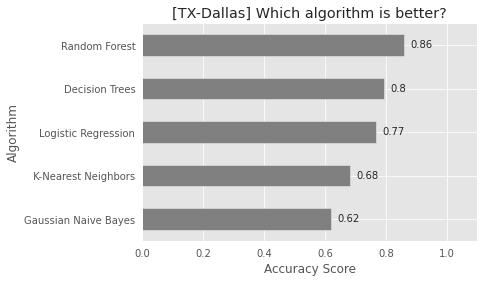

In [0]:
# accident severity with various supervised machine learning algorithms for TX
# Plot the accuracy score versus algorithm

# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst_TX)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_TX_algorithms_{}.csv'.format(state1),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}-{}] Which algorithm is better?'.format(state1, county1))

plt.show()


We could observe that Random forest performs the best with an accuracy score of 86% on the Dallas County.

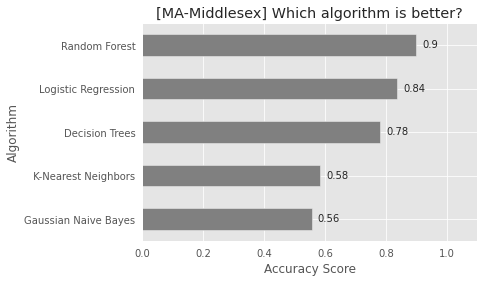

In [0]:
# accident severity with various supervised machine learning algorithms for MA
# Plot the accuracy score versus algorithm

# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst_MA)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_MA_algorithms_{}.csv'.format(state2),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}-{}] Which algorithm is better?'.format(state2, county2))

plt.show()



We could observe that Random forest performs the best with an accuracy score of 90% even on the Middlesex County.

#### Neural Nets

Create a model to classify the Accident Severity by text description.

In [0]:
for i in range(15):
    print(text_data['Description'].iloc[i])

At I-280/OH-420/Exit 71 - Accident.
Accident on I-476 Southbound from Exit 44 to Exits 31 31A 31B PA-63 Sumneytown Pike.
Right hand shoulder blocked due to accident on I-295 Southbound before Exit 51 US-90 Beach Blvd.
Accident on Memorial Hwy at Independence Pkwy.
Accident on I-805 Southbound at Exit 21 CA-274 Balboa Ave.
Accident on SC-215 Blackstock Rd at Cinder Ridge Dr.
At CR-613/Flanders Netcong Rd - Accident.
Accident on Penn Ave at I-240 Service Rd.
Accident a motorcycle involved on Haverhill St at Rustic Ln.
Accident on Greenbriar Rd at Southwest Pkwy.
Accident on I-264 Eastbound at Exits 11 12 I-65.
At I-80/Exit 304 - Accident.
Restrictions due to accident and fallen power cables on 76th St at Parkview Blvd.
Accident on I-77 Southbound at Brookshire Fwy.
Multi-vehicle accident on I-90 Westbound at Exit 188 I-271.


In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_data['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1822 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(text_data['Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(text_data['Severity']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (1000, 500)
Shape of label tensor: (1000, 3)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(900, 500) (900, 3)
(100, 500) (100, 3)


In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# choose epochs and batch_size
epochs = 15
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 810 samples, validate on 90 samples
Epoch 1/15
810/810 [==============================] - 10s 13ms/step - loss: 0.9409 - accuracy: 0.6247 - val_loss: 0.8641 - val_accuracy: 0.6000
Epoch 2/15
810/810 [==============================] - 10s 12ms/step - loss: 0.7066 - accuracy: 0.6642 - val_loss: 0.7794 - val_accuracy: 0.6222
Epoch 3/15
810/810 [==============================] - 10s 12ms/step - loss: 0.6123 - accuracy: 0.7420 - val_loss: 0.7002 - val_accuracy: 0.7444
Epoch 4/15
810/810 [==============================] - 10s 12ms/step - loss: 0.5170 - accuracy: 0.7852 - val_loss: 0.5913 - val_accuracy: 0.8111
Epoch 5/15
810/810 [==============================] - 10s 12ms/step - loss: 0.4486 - accuracy: 0.8284 - val_loss: 0.4916 - val_accuracy: 0.8444
Epoch 6/15
810/810 [==============================] - 10s 12ms/step - loss: 0.3616 - accuracy: 0.8679 - val_loss: 0.4243 - val_accuracy: 0.8222
Epoch 7/15
810/810 [==============================] - 10s 12ms/step - loss: 0.3255 - accura

In [0]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

100/100 [==============================] - 0s 3ms/step
Test set
  Loss: 0.241
  Accuracy: 0.910


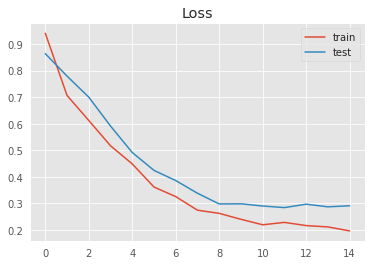

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

Based on the above analysis, we created a model which predicts the Severity of the accident just by the description of the accident with an accuracy greater than 85%. 